In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import hashlib
from mpl_toolkits.mplot3d import Axes3D


## Generation of initial conditions and control parameters

Shape of image: 300 300 3
SHA-256 hash: 5a0656d14c5caaf2361dff71d46371792bb03aa47d0ee8ab2f56e2bb53765269


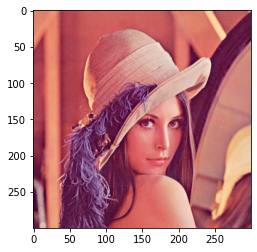

In [2]:
filename = 'Lenna.png'
image = cv2.imread(filename, 1)

#cv2.imshow('Original Image', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

rows, cols, channels = image.shape
print('Shape of image:',rows, cols, channels)
M=rows
N=cols
#file=open("myfile2.txt","w")

#Key variables-----------------------------
alpha_shah = 29
beta_shah = 15
gamma_shah = 8
delta_shah = 9

u = 3.94

a_shah=128
b_shah=255
c_shah=100

#Control parameters ----------------------------
f_lorenz = 10
g_lorenz = 8/3
r_lorenz = 28
step_lorenz = 100

a_chen = 36
b_chen = 3
c_chen = 28
d_chen = 16
k_chen = 0.2
step_chen = 1000


#initial conditions ------------------------------------
a_PWLCM = [0.123456789010]
p0_PWLCM = 0.234578900

y_lorenz = [0.6789012346]
z_lorenz = [0.7890123456]
q_lorenz = [0.6890123450]

u_chen = [0.3456789012]
v_chen = [0.245789012]
w_chen = [0.4567890124]
x_chen = [0.5678901234]


sha256_hash = hashlib.sha256()
with open(filename,"rb") as f:
    # Read and update hash string value in blocks of 4K
    for byte_block in iter(lambda: f.read(4096),b""):
        sha256_hash.update(byte_block)
    digest = sha256_hash.hexdigest()
print('SHA-256 hash:',digest)
m=[]
for i in range(8):
    m.append(int(digest[7*i:7*i+7],16)/pow(2,34))
    #print(digest[7*i:7*i+7])

#print(digest[56:64])
d = int(digest[56:64],16)/pow(2,42)
#print(m,d)

CK = (a_PWLCM[0] + p0_PWLCM + u_chen[0] + v_chen[0] + w_chen[0] + x_chen[0] + y_lorenz[0] + z_lorenz[0] + q_lorenz[0]) % 1
a_PWLCM[0] = a_PWLCM[0] + m[0] + CK
p0_PWLCM = (p0_PWLCM + m[1] + CK) % 1
u_chen[0] = (u_chen[0] + m[2] + CK) % 1
v_chen[0] = (v_chen[0] + m[3] + CK) % 1
w_chen[0] = (w_chen[0] + m[4] + CK) % 1
x_chen[0] = (x_chen[0] + m[5] + CK) % 1
y_lorenz[0] = (y_lorenz[0] + m[6] + CK) % 1
z_lorenz[0] = (z_lorenz[0] + m[7] + CK) % 1
q_lorenz[0] = (q_lorenz[0] + d + CK) % 1


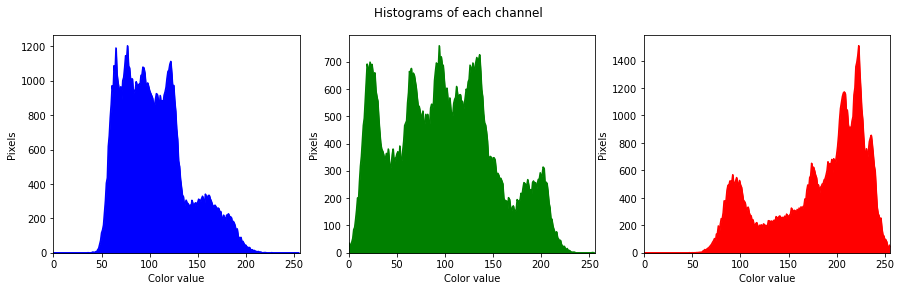

In [3]:
def PWLCM(a,size):
    for i in range(1,size):
        if(a[i-1]<p0_PWLCM):
            a.append(a[i-1]/p0_PWLCM)
        elif(a[i-1]<0.5):
            a.append((a[i-1]-p0_PWLCM)/(0.5-p0_PWLCM))
        else:
            a.append(1-a[i-1])


def lorenz(y,z,q,size):
    for i in range(1,size):
        y.append(y[i-1] + (f_lorenz * (z[i-1] - y[i-1]))/step_lorenz)
        z.append(z[i-1] + (r_lorenz * y[i-1] - z[i-1] - y[i-1] * q[i-1])/step_lorenz)
        q.append(q[i-1] + (y[i-1] * z[i-1] - g_lorenz * q[i-1])/step_lorenz)

def chen(u,v,w,x,size):
    for i in range(1,size):
        u.append(u[i-1] + (a_chen*(v[i-1]-u[i-1]))/step_chen)
        v.append(v[i-1] + (u[i-1]*(c_chen+d_chen-w[i-1])-x[i-1])/step_chen)
        w.append(w[i-1] + (u[i-1]*v[i-1]-b_chen*w[i-1])/step_chen)
        x.append(x[i-1] + (u[i-1]+k_chen)/step_chen)



def hist(image):
    # tuple to select colors of each channel line
    colors = ("b", "g", "r")
    channel_ids = (0, 1, 2)

    # create the histogram plot, with three lines, one for
    # each color
    fig,ax = plt.subplots(1,3)
    fig.suptitle('Histograms of each channel')
    fig.set_figwidth(15)
    
    
    for channel_id, c in zip(channel_ids, colors):
        ax[channel_id].set_xlim([0, 256])
        histogram, bin_edges = np.histogram(image[:, :, channel_id], bins=256, range=(0, 256))
        ax[channel_id].plot(bin_edges[0:-1], histogram, color=c)
        ax[channel_id].fill_between(bin_edges[0:-1], histogram,color=c)
        ax[channel_id].set_ylim(ymin=0)
        ax[channel_id].set_xlabel("Color value")
        ax[channel_id].set_ylabel("Pixels")
    
hist(image)   

""" lorenz(y_lorenz,z_lorenz,q_lorenz,5000)
chen(u_chen,v_chen,w_chen,x_chen,50000)

fig = plt.figure()  
ax = plt.axes(projection ='3d') 
ax.plot3D(y_lorenz,z_lorenz,q_lorenz, 'blue',linewidth=0.2)
plt.show()

fig = plt.figure()  
ax = plt.axes(projection ='3d') 
ax.plot3D(u_chen,v_chen,w_chen, 'blue',linewidth=0.2)
plt.show() """

print()


## S-BOX GENERATION 

In [4]:

def gf_add(a, b):
    return a ^ b


def gf_mul(p1, p2, irPoly):
    """Multiply two polynomials in GF(2^m)/g(x)"""
    degree = 8

    def i2P(sInt):
        """Convert an integer into a polynomial"""
        return [(sInt >> i) & 1
                for i in reversed(range(sInt.bit_length()))]

    mask1 = mask2 = 1 << degree
    mask2 -= 1
    polyred = reduce(lambda x, y: (x << 1) + y, i2P(irPoly)[1:])

    p = 0
    while p2:
        if p2 & 1:
            p ^= p1
        p1 <<= 1
        if p1 & mask1:
            p1 ^= polyred
        p2 >>= 1
    return p & mask2


def gf_degree(a):
    res = 0
    a >>= 1
    while (a != 0):
        a >>= 1
        res += 1
    return res


def gf_invert(a, irPoly):
    v = irPoly
    g1 = 1
    g2 = 0
    j = gf_degree(a) - 8

    while (a != 1):
        if (j < 0):
            a, v = v, a
            g1, g2 = g2, g1
            j = -j

        a ^= v << j
        g1 ^= g2 << j

        a %= 256  # Emulating 8-bit overflow
        g1 %= 256  # Emulating 8-bit overflow

        j = gf_degree(a) - gf_degree(v)

    return g1


def Fj(y, irPoly):
    #global alpha,beta,gamma,delta
    num = gf_add(gf_mul(alpha_shah, y, irPoly), beta_shah)
    den = gf_add(gf_mul(gamma_shah, y, irPoly), delta_shah)
    # print(num,den)
    if(den == 0):
        return -1
    return gf_mul(num, gf_invert(den, irPoly), irPoly)



irPolies = [0b100011101, 0b100101011, 0b100101101, 0b101001101,
            0b101011111, 0b101100011, 0b101100101, 0b101101001,
            0b110001101, 0b110101001, 0b110000111, 0b111000011,
            0b111100111, 0b111001111, 0b111110101, 0b101110001]
SBoxes = [[0 for j in range(256)]for i in range(16)] #Contains all 16 S-Boxes
InvSBoxes = [[0 for j in range(256)]for i in range(16)] #Contains all 16 Inverse S-Boxes

for i in range(16):
    sum = (255*(256))/2
    index = -1
    for j in range(256):
        SBoxes[i][j] = Fj(j, irPolies[i])
        if(SBoxes[i][j] == -1):
            index = j
        else:
            sum -= SBoxes[i][j]
    SBoxes[i][index] = int(sum)

for i in range(16):
    for j in range(256):
        InvSBoxes[i][SBoxes[i][j]]=j

## Encryption Steps starts

## Permutation

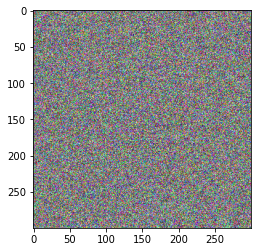

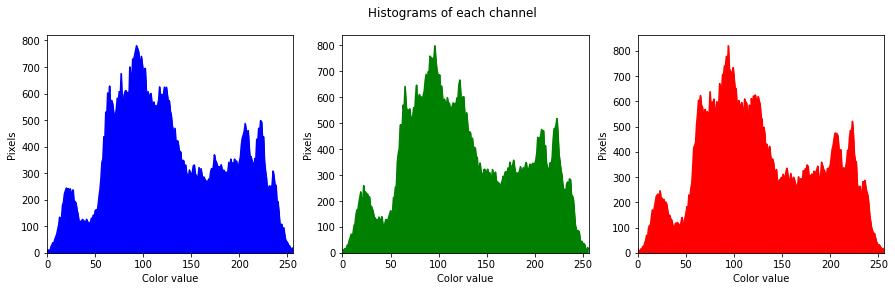

In [5]:
i = 0

PWLCM(a_PWLCM,3*M*N)
for idx in range(len(a_PWLCM)):
    a_PWLCM[idx]=[a_PWLCM[idx],idx]


I = []
for row in range(rows):
    for col in range(cols):
        I.append(image.item(row,col,0))
        I.append(image.item(row,col,1))
        I.append(image.item(row,col,2))


a_PWLCM.sort()
I_dash = []

for idx in range(len(a_PWLCM)):
    I_dash.append(I[a_PWLCM[idx][1]])


#second step
t=100
lorenz(y_lorenz,z_lorenz,q_lorenz,t+M*N)

""" fig = plt.figure()  
ax = plt.axes(projection ='3d') 
ax.plot3D(y_lorenz[:5000],z_lorenz[:5000],q_lorenz[:5000], 'blue',linewidth=0.2)
plt.show() """

y_lorenz=y_lorenz[t:]
z_lorenz=z_lorenz[t:]
q_lorenz=q_lorenz[t:]
for idx in range(M*N):
    y_lorenz[idx]=[y_lorenz[idx],idx]
    z_lorenz[idx]=[z_lorenz[idx],idx]
    q_lorenz[idx]=[q_lorenz[idx],idx]

y_lorenz.sort()
z_lorenz.sort()
q_lorenz.sort()

R = I_dash[0:M*N]
G = I_dash[M*N:2*M*N]
B = I_dash[2*M*N:3*M*N]

R_dash=[]
G_dash=[]
B_dash=[]
for idx in range(M*N):
    R_dash.append(R[y_lorenz[idx][1]])
    G_dash.append(G[z_lorenz[idx][1]])
    B_dash.append(B[q_lorenz[idx][1]])


R_dash = np.reshape(R_dash,(M,N))
G_dash = np.reshape(G_dash,(M,N))
B_dash = np.reshape(B_dash,(M,N))
#print(I[0:5])
#print(I_dash[0:5])


i = 0
for r in range(0, rows):
    for c in range(0, cols):
        image.itemset((r,c,0),R_dash[r][c])
        image.itemset((r,c,1),G_dash[r][c])
        image.itemset((r,c,2),B_dash[r][c])

#cv2.imshow('Encryption step 1(Permutation)', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('Encryption step 1(Permutation).png', image)
hist(image)

## Substituting S box one by one

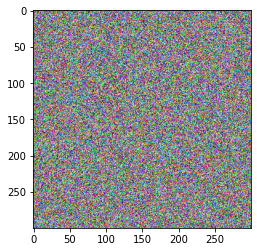

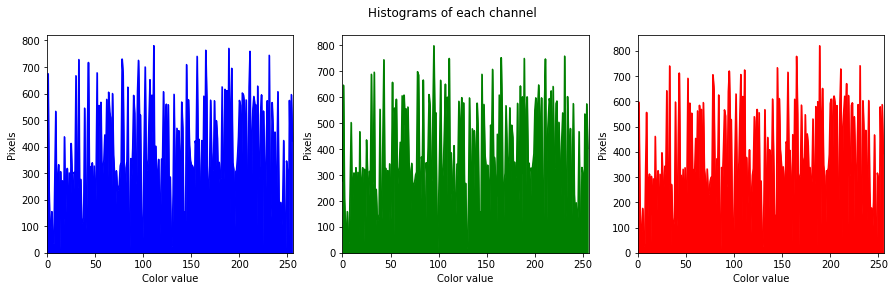

In [6]:
for box_no in range(16):
    for r in range(0, rows):
        for c in range(0, cols):
            blue=image.item(r,c,0)
            green=image.item(r,c,1)
            red=image.item(r,c,2)
            image.itemset((r,c,0),SBoxes[box_no][blue])
            image.itemset((r,c,1),SBoxes[box_no][green])
            image.itemset((r,c,2),SBoxes[box_no][red])


#cv2.imshow('Encryption step 2(S-Box substitution)', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('Encryption step 2(S-Box substitution).png', image)
hist(image)

## Pixel Transposition step

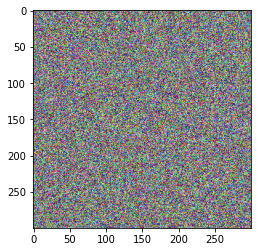

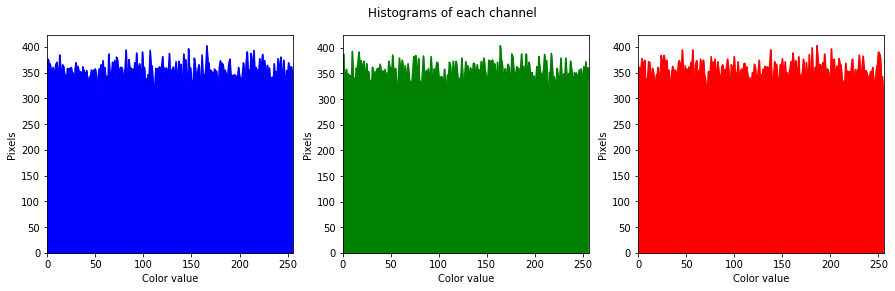

In [7]:


xn=[i%256 for i in range(1,M*N+1)]
xR=[gf_mul(a_shah,i,irPolies[0]) for i in xn]
xG=[gf_mul(b_shah,i,irPolies[2]) for i in xn]
xB=[gf_mul(c_shah,i,irPolies[3]) for i in xn]

chen(u_chen,v_chen,w_chen,x_chen,t+M*N)
u_chen=u_chen[t:]
v_chen=v_chen[t:]
w_chen=w_chen[t:]

for idx in range(M*N):
    u_chen[idx]=[u_chen[idx],idx]
    v_chen[idx]=[v_chen[idx],idx]
    w_chen[idx]=[w_chen[idx],idx]

u_chen.sort()
v_chen.sort()
w_chen.sort()

xR_dash=[]
xG_dash=[]
xB_dash=[]
for idx in range(M*N):
    xR_dash.append(xR[u_chen[idx][1]])
    xG_dash.append(xG[v_chen[idx][1]])
    xB_dash.append(xB[w_chen[idx][1]])


xR_dash = np.reshape(xR_dash,(M,N))
xG_dash = np.reshape(xG_dash,(M,N))
xB_dash = np.reshape(xB_dash,(M,N))


for r in range(0, rows):
    for c in range(0, cols):
        image.itemset((r,c,0),image.item(r,c,0)^xB_dash[r][c])
        image.itemset((r,c,1),image.item(r,c,1)^xG_dash[r][c])
        image.itemset((r,c,2),image.item(r,c,2)^xR_dash[r][c])


cv2.imwrite('Encrypted.png',image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
hist(image)
#cv2.imshow('Fully Encrypted(Pixel transposition)', image)


## Decryption Steps starts

## Pixel Transposition step

True

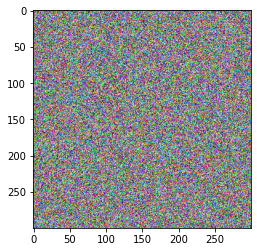

In [8]:
for r in range(0, rows):
    for c in range(0, cols):
        image.itemset((r,c,0),image.item(r,c,0)^xB_dash[r][c])
        image.itemset((r,c,1),image.item(r,c,1)^xG_dash[r][c])
        image.itemset((r,c,2),image.item(r,c,2)^xR_dash[r][c])

#cv2.imshow('Decryption step 1(Pixel Transpostion)', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('Decryption step 1(Pixel Transpostion).png', image)

## Substituting Inverse S boxes one by one

True

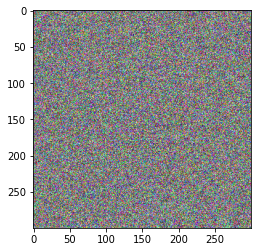

In [9]:
for box_no in range(16):
    for r in range(0, rows):
        for c in range(0, cols):
            blue=image.item(r,c,0)
            green=image.item(r,c,1)
            red=image.item(r,c,2)
            image.itemset((r,c,0),InvSBoxes[15-box_no][blue])#last s box should be substituted first
            image.itemset((r,c,1),InvSBoxes[15-box_no][green])
            image.itemset((r,c,2),InvSBoxes[15-box_no][red])

#cv2.imshow('Decryption step 2(Inverse S-Box substitution)', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.imwrite('Decryption step 2(Inverse S-Box substitution).png', image)


## Repermutation

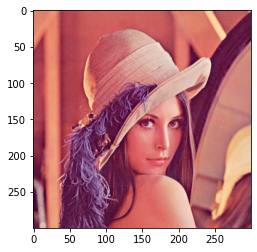

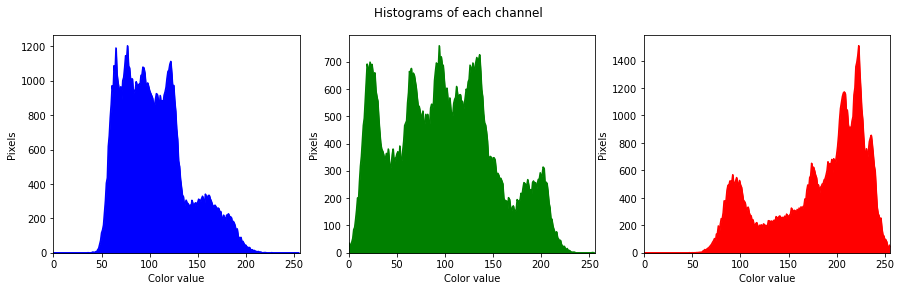

In [10]:
I_dash = []
R_dash = []
G_dash = []
B_dash = []
for row in range(rows):
    for col in range(cols):
        R_dash.append(image.item(row,col,0))
for row in range(rows):
    for col in range(cols):
        G_dash.append(image.item(row,col,1))
for row in range(rows):
    for col in range(cols):
        B_dash.append(image.item(row,col,2))

R = [0]*(M*N)
G = [0]*(M*N)
B = [0]*(M*N)
for idx in range(M*N):
    R[y_lorenz[idx][1]] = R_dash[idx]
    G[z_lorenz[idx][1]] = G_dash[idx]
    B[q_lorenz[idx][1]] = B_dash[idx]

I_dash = R + G + B

I = [0]*len(a_PWLCM)

for idx in range(len(a_PWLCM)):
    I[a_PWLCM[idx][1]]=I_dash[idx]

#print(I[0:5])
#print(I_dash[0:5])
I=np.reshape(I,(-1,cols,3))
i = 0
for row in range(rows):
    for col in range(cols):
        image.itemset((row,col,0),I[row][col][0])
        image.itemset((row,col,1),I[row][col][1])
        image.itemset((row,col,2),I[row][col][2])


cv2.imwrite('Decrypted.png',image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
hist(image)